In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from numba import prange,jit
from scipy.optimize import curve_fit, root_scalar
from matplotlib.animation import FuncAnimation 

In [2]:
# Generates the force based on the displacement between the two polymer atoms

@jit(fastmath=True, nopython=True, nogil=True)
def spring(X, Y, length, K=500):
    distance = np.sqrt(X*X + Y*Y)
    return -K*(distance - length)

In [3]:
# Calculates the end-to-end distance of the polymer

@jit(fastmath=True, nopython=True, nogil=True)
def e2e_distance(p_init, p_fin):
    X = (p_fin[0] - p_init[0])
    Y = (p_fin[1] - p_init[1])
    return np.sqrt(X*X + Y*Y)

In [4]:
# Evolves the points of the polymer due to thermal fluctuation

@jit(fastmath=True, nopython=True, parallel = True, nogil=True)
def animate(pos, bond_length=1, time_step=1e-3, std_deviation=1, spring_constant=100):
    chain_length = pos.shape[0]
    n = chain_length
    l = bond_length
    sigma = std_deviation
    k = spring_constant
    dt = time_step
    sqrt_dt = np.sqrt(dt)
    
    # Stochastic Term
    for i in prange(n):
        pos[i,0] = pos[i,0] + np.random.normal(0.0, sigma)*sqrt_dt
        pos[i,1] = pos[i,1] + np.random.normal(0.0, sigma)*sqrt_dt
        
    # Spring Force term
    for i in range(n):
        F1 = 0
        F2 = 0
        if i!=(n-1):
            x1 = pos[i+1,0] - pos[i,0]
            y1 = pos[i+1,1] - pos[i,1]
            F1 = spring(x1, y1, l, k)
            phi1 = np.arctan2(y1, x1)
        if i!=0:
            x2 = pos[i-1,0] - pos[i,0]
            y2 = pos[i-1,1] - pos[i,1]
            F2 = spring(x2, y2, l, k)
            phi2 = np.arctan2(y2, x2)
        pos[i,0] = pos[i,0] + F1*np.cos(phi1)*dt - F2*np.cos(phi2)*dt
        pos[i,1] = pos[i,1] + F1*np.sin(phi1)*dt - F2*np.sin(phi2)*dt

    return e2e_distance(pos[0,:], pos[n-1,:])

In [4]:
# Evolves the points of the polymer due to thermal fluctuation

@jit(fastmath=True, nopython=True, parallel = True, nogil=True)
def animate(pos, bondLength=1, timeStep=1e-3, stdDeviation=1, springConstant=100, radius=1):
    n = pos.shape[0]
    l = bondLength
    sigma = stdDeviation
    k = springConstant
    dt = timeStep
    sqrtDt = np.sqrt(dt)
    
    intr = np.zeros((n,2))
    
    springF = np.zeros(2)
    xn = 0
    yn = 0
    Fn = 0
    phin = 0
    
    
    # Stochastic Term
    for i in prange(n):
        pos[i,0] = pos[i,0] + np.random.normal(0.0, sigma)*sqrtDt
        pos[i,1] = pos[i,1] + np.random.normal(0.0, sigma)*sqrtDt
        
    # Spring Force term
    for i in range(n):
        force = np.zeros(2)
        if (i!=0) :
            xp = -xn
            yp = -yn
            Fp = spring(xp, yp, l, k)
            phip = np.arctan2(yp, xp)
            force -= np.array([Fp*np.cos(phip), Fp*np.sin(phip)])
        if i!=(n-1):
            xn = pos[i+1,0] - pos[i,0]
            yn = pos[i+1,1] - pos[i,1]
            Fn = spring(xn, yn, l, k)
            phin = np.arctan2(yn, xn)
            force -= np.array([Fn*np.cos(phin), Fn*np.sin(phin)])
        for j in range(i+2, n):
            separation = e2e_distance(pos[i,:], pos[j,:])
            if separation<radius:
                xsi = pos[j,0] - pos[i,0]
                ysi = pos[j,1] - pos[i,1]
                Fsi = -spring(xsi, ysi, radius, k)
                phisi = np.arctan2(ysi, xsi)
                intr[i,0] += Fsi*np.cos(phisi)
                intr[i,1] += Fsi*np.sin(phisi)
                xsj = pos[i,0] - pos[j,0]
                ysj = pos[i,1] - pos[j,1]
                Fsj = -spring(xsj, ysj, radius, k)
                phisj = np.arctan2(ysj, xsj)
                intr[j,0] += Fsj*np.cos(phisj)
                intr[j,1] += Fsj*np.sin(phisj)
        pos[i,0] = pos[i,0] + (force[0] + intr[i,0])*dt
        pos[i,1] = pos[i,1] + (force[1] + intr[i,1])*dt
        
    return e2e_distance(pos[0,:], pos[n-1,:])

In [5]:
#@jit(fastmath=True)
def e2e_time(array, segments, step, length, spring_constant):
    L = array
    n = segments
    l = length
    K = spring_constant
    et = int(1/step)
    time = L.shape[0]
    coordinates = np.zeros((n,2))   # position array
    # Setting the IC
    for i in range(n):
        coordinates[i,0] = i * l
    with open('coordinates.xyz', 'w') as f:
        for j in range(time):
            f.write('\t' + str(n) + '\n')
            f.write("\t" + str(j) + '\n')
            for m in range(coordinates.shape[0]):
                a = np.around(coordinates[m,0],3)
                b = np.around(coordinates[m,1],3)
                f.write("G \t %8.3f \t %8.3f \t %8.3f \n" %(a, b, 0))
            L[j] = animate(coordinates, l, step, 1, K)
    return L

In [6]:
@jit(fastmath=True, nopython=True, parallel = True, nogil=True)
def yes_n(size, time, step, length, K):
    dist_sum = 0
    n = size
    coordinates = np.zeros((n,2))   # position array
    # Setting the IC
    for f in prange(n):
        coordinates[f,0] = f * length

    for m in range(int(1e6)):
        animate(coordinates, length, step, 1, K)

    for j in range(time):
        dist_sum += animate(coordinates, length, step, 1, K)
    return dist_sum/time

In [7]:
n = 16
l = 1                  # bond length
t = int(1e7)           # simulation time
s = 1e-4               # step length
k = 100                # spring constant

# e2e_time(array, segments, step, length, spring_constant)
# T = np.zeros(int(1e4))
# e2e_time(T, n, s, l, k)

In [ ]:
yes_n(16, t, s, l, k)

In [ ]:
yes_n(32, t, s, l, k)

In [ ]:
yes_n(64, t, s, l, k)

In [ ]:
yes_n(128, t, s, l, k)

In [ ]:
yes_n(256, t, s, l, k)

In [ ]:
yes_n(512, t, s, l, k)

In [29]:
yes_n(1024, t, s, l, k)

nan

NameError: name 's' is not defined

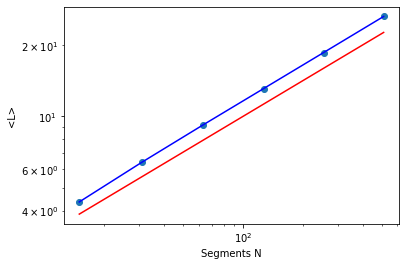

In [19]:
y = np.array([4.36, 6.41, 9.21, 13.1, 18.6, 26.4])

x = np.array([15, 31, 63, 127, 255, 511])
plt.plot(x, y, 'b')
plt.scatter(x, y)
plt.plot(x, np.sqrt(x), 'r')
plt.yscale("log")
plt.ylabel('<L>')
plt.xscale("log")
plt.xlabel('Segments N')
plt.title('Step=' + str(s) + " Time=" + str(t)+" k="+str(k))
plt.tight_layout()

l = time.localtime()
#d8tym = (str(l.tm_mday) + "-" +  str(l.tm_mon) + "at" + str(l.tm_hour) + ":" + str(l.tm_min) + ":" + str(l.tm_sec))

#plt.savefig("Plots/Fig_n="+str(n)+"t="+str(t)+"s="+str(s)+"k="+str(k)+"time:" + d8tym +".png")
plt.show()

In [5]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

/tmp/ipykernel_70789/216347341.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, 1.1767117125411497*np.sqrt(x)-0.1833794544952838, 'r-', label='$N^{1/2}$', color='blue')


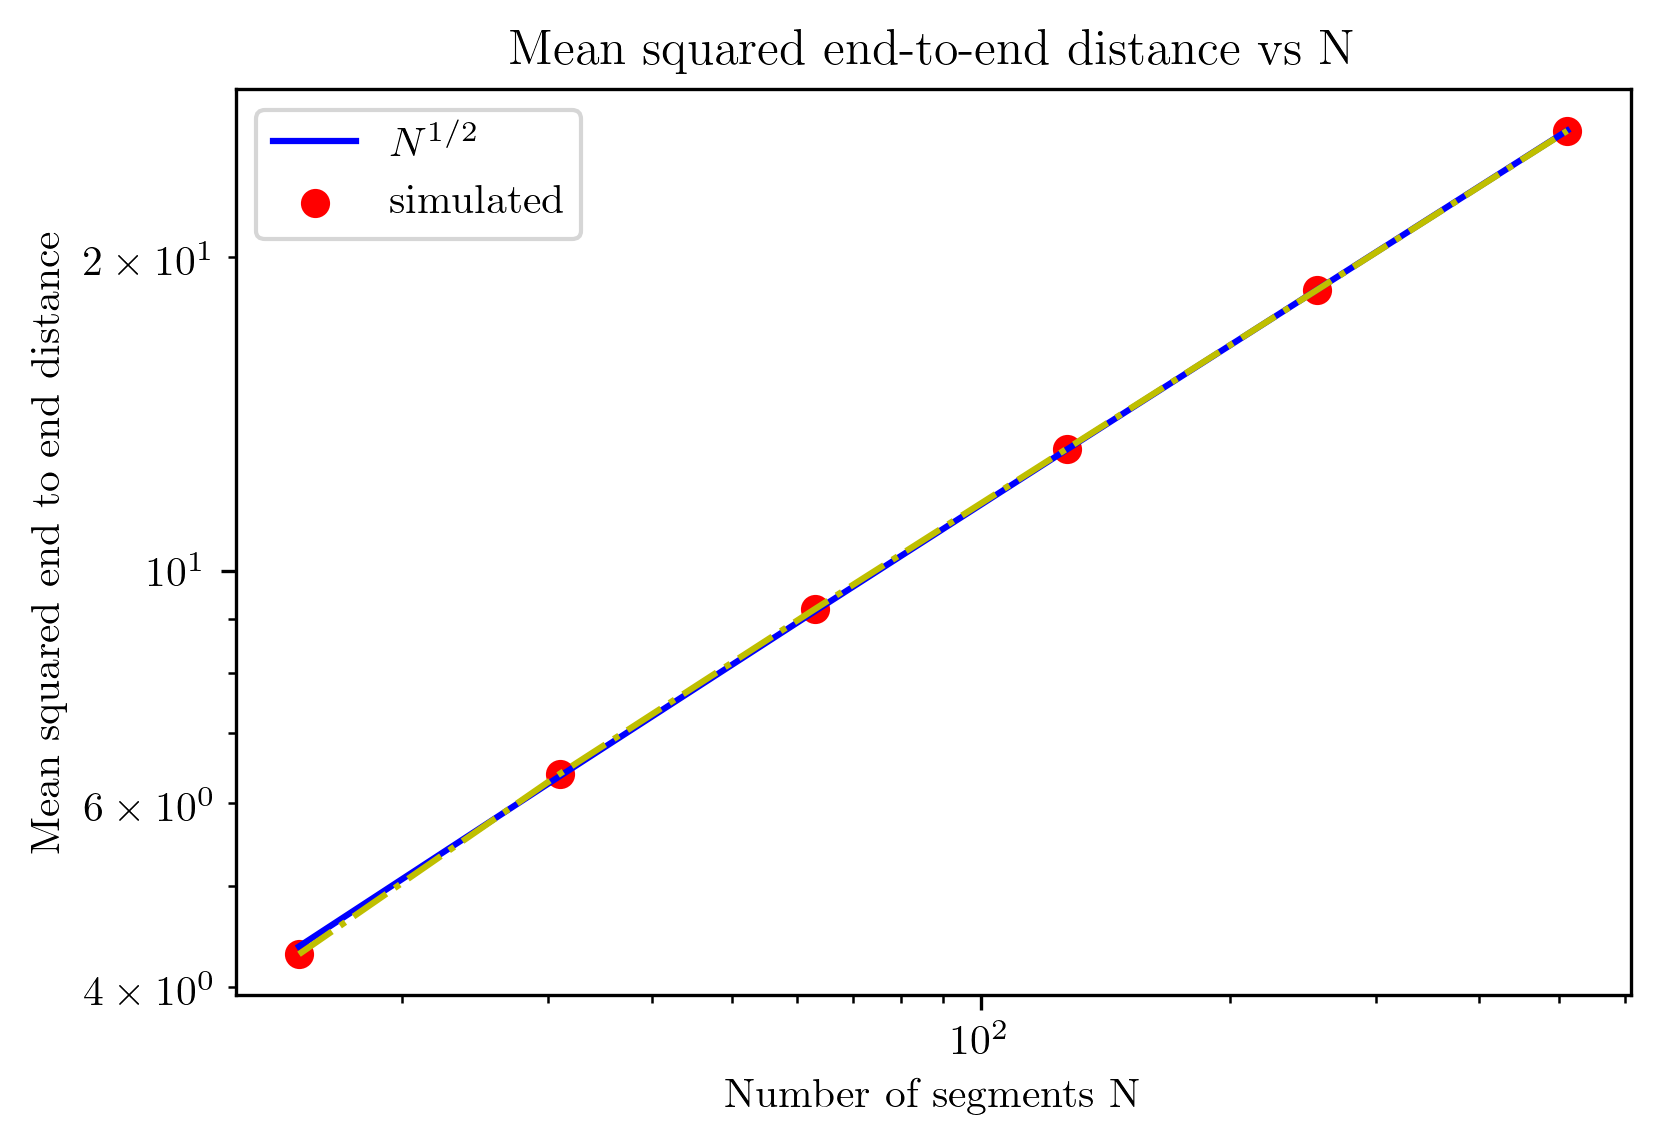

In [6]:
y = np.array([4.3, 6.4, 9.2, 13.1, 18.6, 26.4])
x = np.array([15, 31, 63, 127, 255, 511])

def func(x, a, c):
    return a*x**(1/2) + c
plt.figure(dpi=300)
popt, pcov = curve_fit(func, x, y,)
plt.plot(x, 1.1767117125411497*np.sqrt(x)-0.1833794544952838, 'r-', label='$N^{1/2}$', color='blue')
plt.plot(x, y, 'y-.')
plt.scatter(x, y, color='red',  label='simulated')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of segments N")
plt.ylabel("Mean squared end to end distance")
plt.legend()
plt.title("Mean squared end-to-end distance vs N")
plt.savefig("Polymer_plot.png")
plt.show()


In [32]:
print(*popt)

1.1767117125411497 -0.1833794544952838


In [17]:
dd = np.zeros([10,2])
for i in range(2,10):
    dd[i,:] += [i,1]

In [18]:
print(dd)

[[0. 0.]
 [0. 0.]
 [2. 1.]
 [3. 1.]
 [4. 1.]
 [5. 1.]
 [6. 1.]
 [7. 1.]
 [8. 1.]
 [9. 1.]]


In [71]:
for i in range(2,n):
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
